In [1]:
# For importing files saved in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# NLP Question 1

### Importing all essential libaries

In [2]:
import time
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from io import open
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from IPython.display import clear_output

### Dictionary Object

In [3]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)

### Corpus object

In [4]:
class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.test = self.tokenize(os.path.join(path, 'test.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r', encoding="utf8") as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r', encoding="utf8") as f:
            idss = []
            for line in f:
                words = line.split() + ['<eos>']
                ids = []
                for word in words:
                    ids.append(self.dictionary.word2idx[word])
                idss.append(torch.tensor(ids).type(torch.int64))
            ids = torch.cat(idss)

        return ids

### The FNN Model

In [5]:
class FNNModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size, h, tie_weights=False):
        super(FNNModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size, bias = False)
        if tie_weights:
            if h != embedding_dim:
                raise ValueError('h must equal embedding_dim')
            self.linear2.weight = self.embeddings.weight


    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        out = torch.tanh(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
        

### Important arguments

In [6]:
args_data = '/content/drive/MyDrive/CZ4045 NLP/wikitext-2'
args_embedding_size = 200
args_learning_rate = 0.001
args_epochs = 40
args_batch_size = 64
args_seed = 1111
args_log_interval = 200
args_save = 'model-merged.pt'
args_outf = 'generated.txt'
args_words = 1000
args_temperature = 1.0
args_context_size = 7
args_H = 200
args_cuda = True

### Setting Cuda as main device

In [7]:
torch.manual_seed(args_seed)
device = torch.device("cuda" if args_cuda else "cpu")

### Adding text to dictionary

In [8]:
corpus = Corpus(args_data)

### Creating the dataset

In [9]:
def create_dataset(data, bsz):
    X_values = []
    y_values = []
    for i in range(len(data) - args_context_size - 1):
        X = data[i : i + args_context_size]
        y = data[i+args_context_size]
        X_values.append(X)
        y_values.append(y)
    X_values = torch.stack(X_values)
    y_values = torch.stack(y_values)
    dataset = TensorDataset(X_values, y_values)
    loader = DataLoader(dataset, bsz)
    return loader

In [10]:
train_data = create_dataset(corpus.train, args_batch_size)
test_data = create_dataset(corpus.test, args_batch_size)
val_data = create_dataset(corpus.valid, args_batch_size)

### Setting Model Parameters

Set `False` for no sharing of embeddings and `True` for sharing of embeddings.

In [11]:
ntokens = len(corpus.dictionary)
model = FNNModel(ntokens, args_embedding_size, args_context_size, args_H, True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), args_learning_rate)

In [12]:
def evaluate(datasource):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for _, data in enumerate(datasource):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            output = output.view(-1, ntokens)
            total_loss.append(criterion(output, targets).item())
    
    return np.mean(total_loss)

### Training the Model

In [ ]:
# Loop over epochs.
best_val_ppl = None
count = 0
tr_loss = []
v_loss = []
tr_perp = []
v_perp = []

# At any point you can press the stop button to break out of training early.
try:
    for epoch in range(1, args_epochs+1):
        epoch_start_time = time.time()
        
        progress = tqdm(train_data, unit='batch', desc=f'Epoch: {epoch}', leave=False)
        
        model.train()
        total_loss = []
        for i, data in enumerate(progress):
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            output = output.view(-1, ntokens)
            loss = criterion(output, targets)
            loss.backward()
            total_loss.append(loss.item())
            optimizer.step()
        
        train_loss = np.mean(total_loss)
        train_ppl = math.exp(train_loss)
        
        val_loss = evaluate(val_data)
        val_ppl = math.exp(val_loss)
        progress.write(f'Epoch: {epoch:3d} | time: {(time.time() - epoch_start_time):5.2f}s | train_loss:{train_loss:5.2f} | train_ppl:{train_ppl:8.2f} | val_loss:{val_loss:5.2f} | val_ppl:{val_ppl:8.2f}')
        progress.write('-' * 102)

        tr_loss.append(train_loss)
        tr_perp.append(train_ppl)
        v_loss.append(val_loss)
        v_perp.append(val_ppl)
        
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_ppl or val_ppl < best_val_ppl:
            with open(args_save, 'wb') as f:
                torch.save(model, f)
            best_val_ppl = val_ppl
        else:
            # Early stopping
            count += 1
            if count >=5:
                raise KeyboardInterrupt
except KeyboardInterrupt:
    print('-' * 102)
    print('Exiting from training early')

Epoch:   1 | time: 300.17s | train_loss: 7.77 | train_ppl: 2379.42 | val_loss: 7.43 | val_ppl: 1691.66
------------------------------------------------------------------------------------------------------


Epoch:   2 | time: 298.74s | train_loss: 6.94 | train_ppl: 1035.68 | val_loss: 7.28 | val_ppl: 1453.21
------------------------------------------------------------------------------------------------------


Epoch:   3 | time: 299.11s | train_loss: 6.81 | train_ppl:  911.23 | val_loss: 7.21 | val_ppl: 1353.80
------------------------------------------------------------------------------------------------------


Epoch:   4 | time: 300.47s | train_loss: 6.77 | train_ppl:  868.85 | val_loss: 7.19 | val_ppl: 1321.95
------------------------------------------------------------------------------------------------------


Epoch:   5 | time: 300.63s | train_loss: 6.74 | train_ppl:  848.92 | val_loss: 7.18 | val_ppl: 1307.74
------------------------------------------------------------------------------------------------------


Epoch:   6 | time: 298.39s | train_loss: 6.73 | train_ppl:  835.86 | val_loss: 7.17 | val_ppl: 1295.77
------------------------------------------------------------------------------------------------------


Epoch:   7 | time: 298.94s | train_loss: 6.72 | train_ppl:  825.41 | val_loss: 7.16 | val_ppl: 1284.00
------------------------------------------------------------------------------------------------------


Epoch:   8 | time: 298.73s | train_loss: 6.71 | train_ppl:  817.46 | val_loss: 7.15 | val_ppl: 1276.23
------------------------------------------------------------------------------------------------------


Epoch:   9 | time: 298.80s | train_loss: 6.70 | train_ppl:  809.62 | val_loss: 7.14 | val_ppl: 1265.12
------------------------------------------------------------------------------------------------------


Epoch:  10 | time: 298.97s | train_loss: 6.69 | train_ppl:  802.53 | val_loss: 7.14 | val_ppl: 1256.04
------------------------------------------------------------------------------------------------------


Epoch:  11 | time: 299.04s | train_loss: 6.68 | train_ppl:  797.13 | val_loss: 7.13 | val_ppl: 1252.33
------------------------------------------------------------------------------------------------------


Epoch:  12 | time: 298.67s | train_loss: 6.67 | train_ppl:  791.89 | val_loss: 7.13 | val_ppl: 1244.39
------------------------------------------------------------------------------------------------------


Epoch:  13 | time: 298.87s | train_loss: 6.67 | train_ppl:  787.99 | val_loss: 7.12 | val_ppl: 1237.12
------------------------------------------------------------------------------------------------------


Epoch:  14 | time: 298.68s | train_loss: 6.66 | train_ppl:  783.27 | val_loss: 7.12 | val_ppl: 1239.00
------------------------------------------------------------------------------------------------------


Epoch:  15 | time: 299.03s | train_loss: 6.66 | train_ppl:  780.19 | val_loss: 7.12 | val_ppl: 1234.20
------------------------------------------------------------------------------------------------------


Epoch:  16 | time: 300.05s | train_loss: 6.65 | train_ppl:  776.48 | val_loss: 7.11 | val_ppl: 1224.94
------------------------------------------------------------------------------------------------------


Epoch:  17 | time: 300.31s | train_loss: 6.65 | train_ppl:  774.36 | val_loss: 7.12 | val_ppl: 1236.82
------------------------------------------------------------------------------------------------------


Epoch:  18 | time: 300.04s | train_loss: 6.65 | train_ppl:  773.93 | val_loss: 7.12 | val_ppl: 1238.60
------------------------------------------------------------------------------------------------------


Epoch:  19 | time: 300.43s | train_loss: 6.65 | train_ppl:  771.69 | val_loss: 7.11 | val_ppl: 1225.58
------------------------------------------------------------------------------------------------------


Epoch:  20 | time: 300.20s | train_loss: 6.65 | train_ppl:  770.19 | val_loss: 7.11 | val_ppl: 1224.46
------------------------------------------------------------------------------------------------------


Epoch:  21 | time: 298.44s | train_loss: 6.64 | train_ppl:  768.29 | val_loss: 7.11 | val_ppl: 1229.04
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Exiting from training early


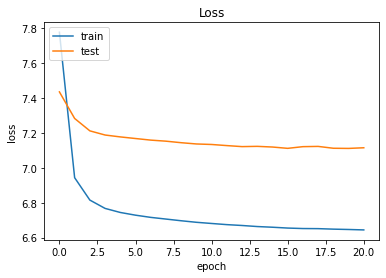

In [ ]:
plt.plot(tr_loss)
plt.plot(v_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

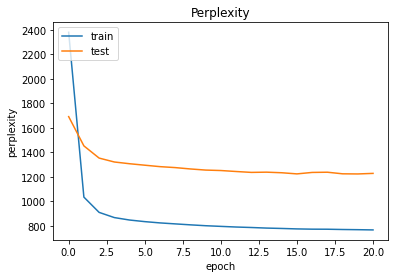

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(tr_perp)
plt.plot(v_perp)
plt.title('Perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('Original Perplexity.png')

### Loading best model

In [ ]:
# Load the best saved model.
with open(args_save, 'rb') as f:
    model = torch.load(f).to(device)

### Evaluating best model

In [ ]:
# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  7.00 | test ppl  1099.69


### Generating new text

In [ ]:
if args_temperature < 1e-3:
    parser.error("--temperature has to be greater or equal 1e-3")

model.eval()
input = torch.randint(ntokens, (1, args_context_size), dtype=torch.long).to(device)

with open(args_outf, 'w') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args_words):
            output = model(input)
            word_weights = output[-1].squeeze().div(args_temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            word_tensor = torch.Tensor([[word_idx]]).long().to(device)
            input = input[0][1:].view((1, -1))
            input = torch.cat((input, word_tensor), 1)

            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args_log_interval == 0:
                print('| Generated {}/{} words'.format(i, args_words))

| Generated 0/1000 words
| Generated 200/1000 words
| Generated 400/1000 words
| Generated 600/1000 words
| Generated 800/1000 words
